In [1]:
#!pip install --quiet optuna
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"[INFO]: Using {device} device")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00
[INFO]: Using cuda:0 device


In [2]:
# Load your dataset
df = pd.read_csv('../data/combined_data_2012_2018.csv')

# Sort by date
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(by='Date')

# Calculate percentage change (Gain/Loss)
df['Gain/Loss'] = df['Close'].pct_change(fill_method=None) * 100

# Drop the first row which will have NaN in the 'Gain/Loss' column
df = df.dropna(subset=['Gain/Loss'])

# Show samples of new field
print(df.head())


        Date        Close                                               News  \
1 2012-01-03  3700.800049  RBI to buy Rs 12,000 cr govt securities: The R...   
2 2012-01-04  3695.050049  Irda issues uniform norms to ensure solvency o...   
3 2012-01-05  3696.149902  PSU banks to get Rs 17K-cr capital infusion in...   
4 2012-01-06  3694.800049  Short-term growth sacrifice inevitable in infl...   
7 2012-01-10  3785.350098  Banks can go below basel levels during crisis:...   

   Gain/Loss  
1   2.728662  
2  -0.155372  
3   0.029766  
4  -0.036521  
7   2.270825  


In [3]:
# Function to create sequences of past n days' Gain/Loss data
def create_sequences(df, seq_len):
    sequences = []
    for i in range(seq_len, len(df)):
        seq = df['Gain/Loss'].values[i-seq_len:i]  # Take past `seq_len` days
        target = df['Gain/Loss'].values[i]  # The target is the Gain/Loss of the next day
        sequences.append((seq, target))
    return sequences


# Tokenize the news headlines for each date
def tokenize_news_headlines(df, tokenizer):
    news_tokens = []
    for headline in df['News'].values:
        tokens = tokenizer(headline, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        news_tokens.append(tokens['input_ids'].squeeze(0))  # Store tokenized ids only
    return torch.stack(news_tokens)


def create_dataloader(SEQ_LEN, BATCH_SIZE):

  # Create sequences of past 5 days' Gain/Loss
  sequences = create_sequences(df, SEQ_LEN)

  # Convert to pandas DataFrame for convenience
  sequences_df = pd.DataFrame(sequences, columns=['Past_Gain_Loss', 'Target'])

  # Tokenizer from Huggingface BERT (can be changed to another tokenizer if needed)
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

  # Tokenize the news headlines
  news_tokens = tokenize_news_headlines(df[SEQ_LEN:], tokenizer)  # Skip the first `SEQ_LEN` rows

  # Convert the sequences into tensors for PyTorch
  gain_loss_sequences = torch.tensor([x[0] for x in sequences], dtype=torch.float32)
  gain_loss_targets = torch.tensor([x[1] for x in sequences], dtype=torch.float32)
  # Convert the sequences into tensors for PyTorch and ensure the correct shape
  gain_loss_sequences = torch.tensor([x[0] for x in sequences], dtype=torch.float32).unsqueeze(-1)  # Add extra dimension for input_size=1
  gain_loss_targets = torch.tensor([x[1] for x in sequences], dtype=torch.float32)

  # Split the data into train and test sets
  X_train_loss, X_test_loss, X_train_news, X_test_news, y_train, y_test = train_test_split(
      gain_loss_sequences, news_tokens, gain_loss_targets, test_size=0.2, shuffle=False
  )

  # Convert training and test data to PyTorch datasets
  train_dataset = torch.utils.data.TensorDataset(X_train_loss, X_train_news, y_train)
  test_dataset = torch.utils.data.TensorDataset(X_test_loss, X_test_news, y_test)

  # Dataloaders for batching
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  return train_loader, test_loader

In [4]:
class StockPredictionModel(nn.Module):
    def __init__(self, lstm_input_dim, lstm_hidden_dim, lstm_num_layers, bert_model_name="bert-base-uncased"):
        super(StockPredictionModel, self).__init__()

        # LSTM for Gain/Loss time-series data
        self.lstm = nn.LSTM(
            input_size=lstm_input_dim,  # input size is 1, representing the Gain/Loss per day
            hidden_size=lstm_hidden_dim,  # hidden layer size of the LSTM
            num_layers=lstm_num_layers,  # number of LSTM layers
            batch_first=True  # batch dimension comes first in the input
        ).to(device)
        self.fc_lstm = nn.Linear(lstm_hidden_dim, 32).to(device)  # Linear layer after LSTM to reduce the output dimension

        # BERT model for news headlines
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.fc_bert = nn.Linear(768, 32)  # Reduce BERT's output size from 768 to 32

        # Fully connected layer to combine both LSTM and BERT outputs
        self.fc_combined = nn.Linear(32 + 32, 1)  # Combine LSTM and BERT outputs into one prediction

    def forward(self, gain_loss_seq, news_tokens):
        # Process Gain/Loss time-series data with LSTM
        lstm_out, (hn, cn) = self.lstm(gain_loss_seq)  # lstm_out is (batch_size, seq_len, lstm_hidden_dim)
        lstm_out = self.fc_lstm(lstm_out[:, -1, :])  # We only take the output from the last time step

        # Process news data with BERT
        bert_out = self.bert(input_ids=news_tokens)['pooler_output']  # Take the [CLS] token representation
        bert_out = self.fc_bert(bert_out)  # Reduce the dimensionality to 32

        # Concatenate the LSTM and BERT outputs
        combined_out = torch.cat((lstm_out, bert_out), dim=1)

        # Final prediction
        prediction = self.fc_combined(combined_out)

        return prediction


In [5]:
def train(model,loss_func, optimizer, scheduler, train_loader, test_loader, params, trial=None):
  # Store loss values for plotting
  train_losses = []
  test_losses = []

  for epoch in range(params['epochs']):
    model.train()  # Set model to training mode
    total_train_loss = 0

    # Training phase
    for batch_gain_loss, batch_news, batch_labels in train_loader:
        optimizer.zero_grad()  # Reset gradients

        batch_gain_loss = batch_gain_loss.to(device)
        batch_news = batch_news.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        predictions = model(batch_gain_loss, batch_news)

        # Compute loss
        loss = loss_func(predictions, batch_labels.unsqueeze(-1))  # Reshape labels for MSE

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase (Test set)
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0
    real_targets = []
    predicted_targets = []

    with torch.no_grad():
        for batch_gain_loss, batch_news, batch_labels in test_loader:
            # Get model predictions
            batch_gain_loss = batch_gain_loss.to(device)
            batch_news = batch_news.to(device)
            batch_labels = batch_labels.to(device)

            predictions = model(batch_gain_loss, batch_news)

            # Compute test loss
            loss = loss_func(predictions, batch_labels.unsqueeze(-1))
            total_test_loss += loss.item()

            # Collect real and predicted values for plotting
            real_targets.extend(batch_labels.tolist())  # Actual values
            predicted_targets.extend(predictions.squeeze().tolist())  # Predicted values

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{params["epochs"]}, Training Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

    if(trial):
      trial.report(avg_test_loss, epoch)
      # Handle pruning based on the intermediate value.
      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

  return train_losses, test_losses

In [ ]:
def objective(trial):
  # Used for tuning h-params using Optuna
  params = {
        "epochs": 10,
        "lstm_hidden_dim": trial.suggest_categorical("lstm_hidden_dim", [16,32,64]),
        "lstm_num_layers": trial.suggest_categorical("lstm_num_layers", [1,2,4]),
        "seq_len": trial.suggest_int("seq_len", 3, 10),
        "optimizer_name": trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
        "batch_size": trial.suggest_categorical("batch_size", [16,32]),
        "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        "scheduler_step_size": trial.suggest_int("scheduler_step_size", 1, 10),
        "scheduler_gamma": trial.suggest_float("scheduler_gamma", 0.5, 1),
    }
  loss_func = nn.MSELoss()
  # Initialize the model, loss function, and optimizer
  model = StockPredictionModel(
    lstm_input_dim=1,  # Each input is a single Gain/Loss value per time step
    lstm_hidden_dim=params['lstm_hidden_dim'],  # Hidden state size for LSTM
    lstm_num_layers=params['lstm_num_layers']  # Number of LSTM layers
  ).to(device)

  optimizer = getattr(torch.optim, params['optimizer_name'])(model.parameters(), lr=params['lr'])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])

  #prepare data
  train_loader_list, test_loader_list = create_dataloader(params['seq_len'], params['batch_size'])

  _, test_losses = train(model,loss_func, optimizer, scheduler, train_loader_list, test_loader_list, params, trial)
  return test_losses[-1]



# Tune h-params and show results

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=6000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

fig = plot_param_importances(study)
fig.show()


[I 2024-11-07 11:16:42,318] A new study created in memory with name: no-name-2203d599-1be0-4fb2-9044-a4aa779f9b9c
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/10, Training Loss: 0.9038162342337674, Test Loss: 0.6762555973096327
Epoch 2/10, Training Loss: 0.8917540041513221, Test Loss: 0.6714569113471291
Epoch 3/10, Training Loss: 0.8779617395511893, Test Loss: 0.6959241059693423
Epoch 4/10, Training Loss: 0.8868445189193238, Test Loss: 0.6741712608120658
Epoch 5/10, Training Loss: 0.8753070671891057, Test Loss: 0.6741304207931865
Epoch 6/10, Training Loss: 0.8782175606073335, Test Loss: 0.6698882796547629
Epoch 7/10, Training Loss: 0.872140180232913, Test Loss: 0.669439588080753
Epoch 8/10, Training Loss: 0.7988641726416211, Test Loss: 0.7540282065218146
Epoch 9/10, Training Loss: 0.682646959326988, Test Loss: 1.2282917933030562


[I 2024-11-07 11:21:55,884] Trial 0 finished with value: 0.9037094549699263 and parameters: {'lstm_hidden_dim': 16, 'lstm_num_layers': 2, 'seq_len': 4, 'optimizer_name': 'Adam', 'batch_size': 32, 'lr': 2.520585358561848e-05, 'scheduler_step_size': 7, 'scheduler_gamma': 0.5529086608853266}. Best is trial 0 with value: 0.9037094549699263.


Epoch 10/10, Training Loss: 0.4448212496069975, Test Loss: 0.9037094549699263
Epoch 1/10, Training Loss: 0.8909858887971833, Test Loss: 0.6858503357930616
Epoch 2/10, Training Loss: 0.8900273913560912, Test Loss: 0.6802351203831759
Epoch 3/10, Training Loss: 0.8968645424343819, Test Loss: 0.7437463484027169
Epoch 4/10, Training Loss: 0.8805062978766686, Test Loss: 0.741492512551221
Epoch 5/10, Training Loss: 0.8806041596933852, Test Loss: 0.6759120605208657
Epoch 6/10, Training Loss: 0.8762021120204482, Test Loss: 0.684724360704422
Epoch 7/10, Training Loss: 0.8898631188758584, Test Loss: 0.7310642789710652
Epoch 8/10, Training Loss: 0.8857530119807221, Test Loss: 0.7130357623100281
Epoch 9/10, Training Loss: 0.8671256969141405, Test Loss: 0.6834436357021332


[I 2024-11-07 11:26:58,226] Trial 1 finished with value: 0.715323044495149 and parameters: {'lstm_hidden_dim': 32, 'lstm_num_layers': 4, 'seq_len': 6, 'optimizer_name': 'SGD', 'batch_size': 32, 'lr': 0.005369734549988398, 'scheduler_step_size': 9, 'scheduler_gamma': 0.648679825257144}. Best is trial 1 with value: 0.715323044495149.


Epoch 10/10, Training Loss: 0.8644908001256544, Test Loss: 0.715323044495149
Epoch 1/10, Training Loss: 1381.7777752127759, Test Loss: 0.6738264750350605
Epoch 2/10, Training Loss: 0.8910236732904301, Test Loss: 0.6959623450582678
Epoch 3/10, Training Loss: 0.9167086350363355, Test Loss: 0.6718538078394803
Epoch 4/10, Training Loss: 0.8851974807506384, Test Loss: 0.6712349842895161
Epoch 5/10, Training Loss: 0.9365506449411082, Test Loss: 0.9590749469670382
Epoch 6/10, Training Loss: 0.9575119635393453, Test Loss: 0.8246052427725359
Epoch 7/10, Training Loss: 5.210652643164923, Test Loss: 26.505081350153144
Epoch 8/10, Training Loss: 8.927071410556172, Test Loss: 3.5503299453041772
Epoch 9/10, Training Loss: 4.424510193425555, Test Loss: 4.734976855191317


[I 2024-11-07 11:31:56,793] Trial 2 finished with value: 0.6705594767223705 and parameters: {'lstm_hidden_dim': 16, 'lstm_num_layers': 2, 'seq_len': 4, 'optimizer_name': 'RMSprop', 'batch_size': 32, 'lr': 0.009358141617697662, 'scheduler_step_size': 8, 'scheduler_gamma': 0.891391426810781}. Best is trial 2 with value: 0.6705594767223705.


Epoch 10/10, Training Loss: 6.139883333860442, Test Loss: 0.6705594767223705
Epoch 1/10, Training Loss: 0.8798669548921807, Test Loss: 0.6848413131453774
Epoch 2/10, Training Loss: 0.8963382708471875, Test Loss: 0.6729439808563753
Epoch 3/10, Training Loss: 0.8750277764575426, Test Loss: 0.6731528368863192
Epoch 4/10, Training Loss: 0.8803747046825497, Test Loss: 0.6741761443289843
Epoch 5/10, Training Loss: 0.8770451732846194, Test Loss: 0.6760512834245508
Epoch 6/10, Training Loss: 0.8748276261396186, Test Loss: 0.6832896010442213
Epoch 7/10, Training Loss: 0.8667351977769718, Test Loss: 0.692771619016474
Epoch 8/10, Training Loss: 0.8695495731608812, Test Loss: 0.6806568963961168
Epoch 9/10, Training Loss: 0.8898609765740328, Test Loss: 0.678989892656153


[I 2024-11-07 11:36:57,246] Trial 3 finished with value: 0.6851429505781694 and parameters: {'lstm_hidden_dim': 64, 'lstm_num_layers': 1, 'seq_len': 6, 'optimizer_name': 'SGD', 'batch_size': 32, 'lr': 0.0014120444202133074, 'scheduler_step_size': 8, 'scheduler_gamma': 0.800922830966349}. Best is trial 2 with value: 0.6705594767223705.


Epoch 10/10, Training Loss: 0.8662850142911424, Test Loss: 0.6851429505781694
Epoch 1/10, Training Loss: 0.8949078861404868, Test Loss: 0.6623306348919868
Epoch 2/10, Training Loss: 0.8852935687584036, Test Loss: 0.6492160772058096
Epoch 3/10, Training Loss: 0.8923079041873707, Test Loss: 0.6612052531404928
Epoch 4/10, Training Loss: 0.8897320193402908, Test Loss: 0.6676436181772839
Epoch 5/10, Training Loss: 0.8894645925830392, Test Loss: 0.6457852633161978
Epoch 6/10, Training Loss: 0.8908053228083779, Test Loss: 0.6574557237327099
Epoch 7/10, Training Loss: 0.9133978910305921, Test Loss: 0.6771298572421074
Epoch 8/10, Training Loss: 0.8877784669399261, Test Loss: 0.6838276352394711
Epoch 9/10, Training Loss: 0.8881613124819363, Test Loss: 0.6452796164561402


[I 2024-11-07 11:42:32,065] Trial 4 finished with value: 0.653667848218571 and parameters: {'lstm_hidden_dim': 32, 'lstm_num_layers': 2, 'seq_len': 7, 'optimizer_name': 'Adam', 'batch_size': 16, 'lr': 7.592091670671238e-05, 'scheduler_step_size': 1, 'scheduler_gamma': 0.9188697324448025}. Best is trial 4 with value: 0.653667848218571.


Epoch 10/10, Training Loss: 0.894368631699506, Test Loss: 0.653667848218571
Epoch 1/10, Training Loss: 1.864000628976261, Test Loss: 0.6550320187075571
Epoch 2/10, Training Loss: 0.9988491167040432, Test Loss: 0.9827166917649183
Epoch 3/10, Training Loss: 0.9845764780745787, Test Loss: 0.6883289803835478
Epoch 4/10, Training Loss: 0.9835329325760112, Test Loss: 0.8589759211648594
Epoch 5/10, Training Loss: 0.9365179423023673, Test Loss: 0.6638654185967012
Epoch 6/10, Training Loss: 0.9117053641992456, Test Loss: 0.6688396548005667
Epoch 7/10, Training Loss: 0.8994393068201402, Test Loss: 0.6514803045852617
Epoch 8/10, Training Loss: 0.9009029689957114, Test Loss: 0.6510870896957137
Epoch 9/10, Training Loss: 0.8863227135994856, Test Loss: 0.647690593518994


[I 2024-11-07 11:47:55,967] Trial 5 finished with value: 0.6453331580216234 and parameters: {'lstm_hidden_dim': 64, 'lstm_num_layers': 4, 'seq_len': 6, 'optimizer_name': 'RMSprop', 'batch_size': 16, 'lr': 0.0008194789287810317, 'scheduler_step_size': 10, 'scheduler_gamma': 0.689949334138821}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.886599526598173, Test Loss: 0.6453331580216234
Epoch 1/10, Training Loss: 0.8905662741771964, Test Loss: 0.6712125973267988
Epoch 2/10, Training Loss: 0.8963417618773705, Test Loss: 0.6731266487728466
Epoch 3/10, Training Loss: 0.8861938812011896, Test Loss: 0.6697236326607791
Epoch 4/10, Training Loss: 0.8860138121039368, Test Loss: 0.6778589920564131
Epoch 5/10, Training Loss: 0.8736859393674273, Test Loss: 0.7008214322003451
Epoch 6/10, Training Loss: 0.8844886345918789, Test Loss: 0.6720486337488348
Epoch 7/10, Training Loss: 0.8871763327787089, Test Loss: 0.6741654195568778
Epoch 8/10, Training Loss: 0.8815257805724477, Test Loss: 0.6689552624117244
Epoch 9/10, Training Loss: 0.8817049160946248, Test Loss: 0.6686631061814048


[I 2024-11-07 11:53:03,912] Trial 6 finished with value: 0.6706107394261793 and parameters: {'lstm_hidden_dim': 32, 'lstm_num_layers': 2, 'seq_len': 5, 'optimizer_name': 'Adam', 'batch_size': 32, 'lr': 0.00029638820264792396, 'scheduler_step_size': 10, 'scheduler_gamma': 0.5778280481109181}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.8785340176072232, Test Loss: 0.6706107394261793
Epoch 1/10, Training Loss: 0.9121543972991234, Test Loss: 0.672702663324096
Epoch 2/10, Training Loss: 0.8933045718559, Test Loss: 0.672486582940275
Epoch 3/10, Training Loss: 0.8908071961513785, Test Loss: 0.6733445416797291
Epoch 4/10, Training Loss: 0.8837274742680926, Test Loss: 0.6748527640646155
Epoch 5/10, Training Loss: 0.8875035338623579, Test Loss: 0.6750006079673767


[I 2024-11-07 11:56:09,589] Trial 7 pruned. 


Epoch 6/10, Training Loss: 0.8792951834756274, Test Loss: 0.6746964319185778


[I 2024-11-07 11:56:48,448] Trial 8 pruned. 


Epoch 1/10, Training Loss: 2.1967485560927282, Test Loss: 0.7974802065979351
Epoch 1/10, Training Loss: 0.8835492947522332, Test Loss: 0.6446432149545713
Epoch 2/10, Training Loss: 0.881632268779418, Test Loss: 0.64519961821762
Epoch 3/10, Training Loss: 0.8798922377474168, Test Loss: 0.645341968671842
Epoch 4/10, Training Loss: 0.8827478598145878, Test Loss: 0.6459979875521227
Epoch 5/10, Training Loss: 0.8808470648877761, Test Loss: 0.6460135013542392
Epoch 6/10, Training Loss: 0.8823203553171719, Test Loss: 0.6456834673881531
Epoch 7/10, Training Loss: 0.8785641919164097, Test Loss: 0.6457432599907572
Epoch 8/10, Training Loss: 0.8842510847484364, Test Loss: 0.6455827158960429
Epoch 9/10, Training Loss: 0.8824419892886106, Test Loss: 0.6459134800190275


[I 2024-11-07 12:02:00,560] Trial 9 finished with value: 0.6467047387903387 and parameters: {'lstm_hidden_dim': 16, 'lstm_num_layers': 4, 'seq_len': 9, 'optimizer_name': 'SGD', 'batch_size': 16, 'lr': 0.00013701162108966644, 'scheduler_step_size': 3, 'scheduler_gamma': 0.8954739977671171}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.8776754915714264, Test Loss: 0.6467047387903387


[I 2024-11-07 12:02:41,100] Trial 10 pruned. 


Epoch 1/10, Training Loss: 1.934455563566264, Test Loss: 0.6731420525095679
Epoch 1/10, Training Loss: 0.8896811050527236, Test Loss: 0.6456416696310043
Epoch 2/10, Training Loss: 0.8894505262374878, Test Loss: 0.6457763829014518
Epoch 3/10, Training Loss: 0.880372973224696, Test Loss: 0.6458340608938173
Epoch 4/10, Training Loss: 0.8719706915757235, Test Loss: 0.6618631671775471
Epoch 5/10, Training Loss: 0.8718235001844519, Test Loss: 0.6631555733355609
Epoch 6/10, Training Loss: 0.8800788388532751, Test Loss: 0.6501845060424372
Epoch 7/10, Training Loss: 0.8722901042769937, Test Loss: 0.6538255736231804
Epoch 8/10, Training Loss: 0.8627342192565693, Test Loss: 0.6410273516719992
Epoch 9/10, Training Loss: 0.8122263031847337, Test Loss: 0.7171516716480255


[I 2024-11-07 12:08:08,037] Trial 11 finished with value: 0.9133950095962394 and parameters: {'lstm_hidden_dim': 16, 'lstm_num_layers': 4, 'seq_len': 9, 'optimizer_name': 'RMSprop', 'batch_size': 16, 'lr': 1.0735076453392125e-05, 'scheduler_step_size': 3, 'scheduler_gamma': 0.7469008203190965}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.7014203960404677, Test Loss: 0.9133950095962394
Epoch 1/10, Training Loss: 0.8797366308815339, Test Loss: 0.6478507911617105
Epoch 2/10, Training Loss: 0.8840580833308836, Test Loss: 0.6463847146792845
Epoch 3/10, Training Loss: 0.8992162150495192, Test Loss: 0.6480540240352805
Epoch 4/10, Training Loss: 0.8833140846560983, Test Loss: 0.6482395594092932
Epoch 5/10, Training Loss: 0.8814503347172457, Test Loss: 0.6457304294136438
Epoch 6/10, Training Loss: 0.8814861788469203, Test Loss: 0.646762280640277
Epoch 7/10, Training Loss: 0.8798191901515512, Test Loss: 0.6468352323228662
Epoch 8/10, Training Loss: 0.8711947502458797, Test Loss: 0.6461981717835773
Epoch 9/10, Training Loss: 0.8760510623455048, Test Loss: 0.6488429843024774


[I 2024-11-07 12:13:19,962] Trial 12 finished with value: 0.6474536775865338 and parameters: {'lstm_hidden_dim': 64, 'lstm_num_layers': 4, 'seq_len': 8, 'optimizer_name': 'SGD', 'batch_size': 16, 'lr': 0.0005302300369550395, 'scheduler_step_size': 4, 'scheduler_gamma': 0.9823103528502664}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.875272813614677, Test Loss: 0.6474536775865338
Epoch 1/10, Training Loss: 0.9068745581542744, Test Loss: 0.651439752091061
Epoch 2/10, Training Loss: 0.8915581419187434, Test Loss: 0.6480475454167887
Epoch 3/10, Training Loss: 0.8920526788515203, Test Loss: 0.6497221331704747
Epoch 4/10, Training Loss: 0.8822995145531262, Test Loss: 0.6612375290556387
Epoch 5/10, Training Loss: 0.8824273845728706, Test Loss: 0.6454435790126974
Epoch 6/10, Training Loss: 0.8881677031517029, Test Loss: 0.6455681276592341
Epoch 7/10, Training Loss: 0.8806872245143441, Test Loss: 0.6549826796081933
Epoch 8/10, Training Loss: 0.8824587229420157, Test Loss: 0.6619945822114294
Epoch 9/10, Training Loss: 0.8808083260760587, Test Loss: 0.6541337902573022


[I 2024-11-07 12:18:44,528] Trial 13 finished with value: 0.6524727618829771 and parameters: {'lstm_hidden_dim': 64, 'lstm_num_layers': 4, 'seq_len': 10, 'optimizer_name': 'RMSprop', 'batch_size': 16, 'lr': 6.498878361325977e-05, 'scheduler_step_size': 1, 'scheduler_gamma': 0.6595917345559279}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.8811464360531639, Test Loss: 0.6524727618829771
Epoch 1/10, Training Loss: 0.880132065450444, Test Loss: 0.6480495337058197
Epoch 2/10, Training Loss: 0.8785444994183148, Test Loss: 0.6483410207385366
Epoch 3/10, Training Loss: 0.8813101167187971, Test Loss: 0.6497966420244087
Epoch 4/10, Training Loss: 0.8857986741206225, Test Loss: 0.6481707052073695
Epoch 5/10, Training Loss: 0.8791168426766115, Test Loss: 0.6505556990477172
Epoch 6/10, Training Loss: 0.8799879252910614, Test Loss: 0.6480820741165768
Epoch 7/10, Training Loss: 0.8831766245996251, Test Loss: 0.6481154066595164
Epoch 8/10, Training Loss: 0.8773070521214429, Test Loss: 0.650164504620162
Epoch 9/10, Training Loss: 0.879926274804508, Test Loss: 0.6512593105435371


[I 2024-11-07 12:23:56,047] Trial 14 finished with value: 0.650374208661643 and parameters: {'lstm_hidden_dim': 16, 'lstm_num_layers': 4, 'seq_len': 8, 'optimizer_name': 'SGD', 'batch_size': 16, 'lr': 0.0002309785411007507, 'scheduler_step_size': 3, 'scheduler_gamma': 0.7672997878830872}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.8771889774238362, Test Loss: 0.650374208661643


[I 2024-11-07 12:24:37,368] Trial 15 pruned. 


Epoch 1/10, Training Loss: 3.5432892115677106, Test Loss: 0.8213166323575106
Epoch 1/10, Training Loss: 0.8856519713121302, Test Loss: 0.6474229781465097
Epoch 2/10, Training Loss: 0.8777282430845148, Test Loss: 0.6480141681703654
Epoch 3/10, Training Loss: 0.8798403739929199, Test Loss: 0.6485902047292753
Epoch 4/10, Training Loss: 0.8781178612919415, Test Loss: 0.6480774303728883
Epoch 5/10, Training Loss: 0.8775475836852018, Test Loss: 0.6484828472814776
Epoch 6/10, Training Loss: 0.876973404603846, Test Loss: 0.6493086435578086
Epoch 7/10, Training Loss: 0.8767868592458613, Test Loss: 0.6493429128419269
Epoch 8/10, Training Loss: 0.879296709334149, Test Loss: 0.6478803706440058
Epoch 9/10, Training Loss: 0.8758094678906834, Test Loss: 0.6486302648078311


[I 2024-11-07 12:29:48,426] Trial 16 finished with value: 0.649423574520783 and parameters: {'lstm_hidden_dim': 64, 'lstm_num_layers': 1, 'seq_len': 5, 'optimizer_name': 'SGD', 'batch_size': 16, 'lr': 0.00010496166457591357, 'scheduler_step_size': 2, 'scheduler_gamma': 0.8831009038024155}. Best is trial 5 with value: 0.6453331580216234.


Epoch 10/10, Training Loss: 0.8794952027937946, Test Loss: 0.649423574520783


[I 2024-11-07 12:30:30,272] Trial 17 pruned. 


Epoch 1/10, Training Loss: 1.729917008210631, Test Loss: 0.7149689529429782


[I 2024-11-07 12:31:11,092] Trial 18 pruned. 


Epoch 1/10, Training Loss: 0.9199214521576377, Test Loss: 0.6666563220999457


[I 2024-11-07 12:31:51,824] Trial 19 pruned. 


Epoch 1/10, Training Loss: 1.9003997501204997, Test Loss: 0.8461345840584148
Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  7
  Number of complete trials:  13
Best trial:
  Value:  0.6453331580216234
  Params: 
    lstm_hidden_dim: 64
    lstm_num_layers: 4
    seq_len: 6
    optimizer_name: RMSprop
    batch_size: 16
    lr: 0.0008194789287810317
    scheduler_step_size: 10
    scheduler_gamma: 0.689949334138821


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/10, Training Loss: 2.0016146382864783, Test Loss: 0.7682714096524499
Epoch 2/10, Training Loss: 0.9628287438084098, Test Loss: 1.3830039392818103
Epoch 3/10, Training Loss: 1.0038218976820217, Test Loss: 0.65612239187414
Epoch 4/10, Training Loss: 0.9297204743413364, Test Loss: 0.7553412125191905
Epoch 5/10, Training Loss: 0.9376774794915144, Test Loss: 0.6520854512398894
Epoch 6/10, Training Loss: 0.9225789967705221, Test Loss: 0.6508053446357901
Epoch 7/10, Training Loss: 0.9060790826292598, Test Loss: 0.6465325582433831
Epoch 8/10, Training Loss: 0.895320612893385, Test Loss: 0.6740858646279032
Epoch 9/10, Training Loss: 0.8882527112960815, Test Loss: 0.6560614454475316
Epoch 10/10, Training Loss: 0.8819845914840698, Test Loss: 0.6460341780700467


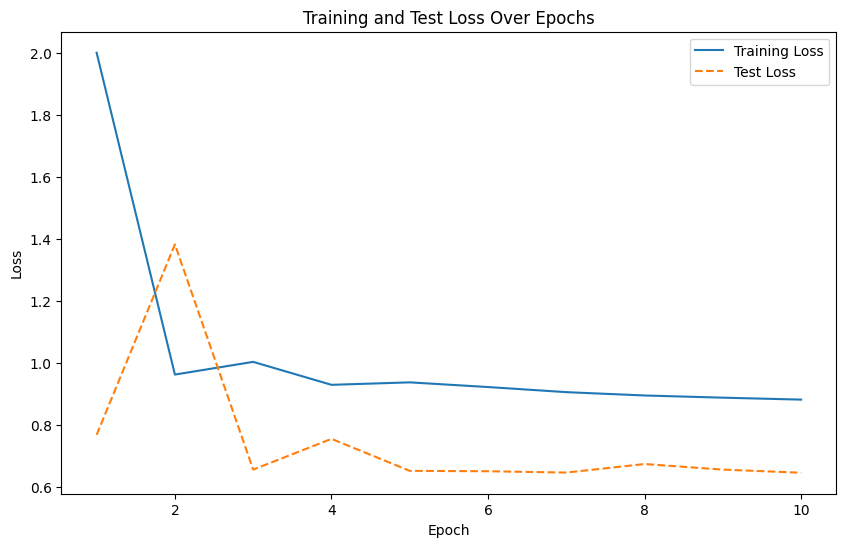

In [10]:
# Define params based on best params from Optuna
params = {
        "epochs": 10,
        "lstm_hidden_dim": 64,
        "lstm_num_layers": 4,
        "seq_len": 6,
        "optimizer_name": 'RMSprop',
        "batch_size": 16,
        "lr": 0.0008194789287810317,
        "scheduler_step_size": 10,
        "scheduler_gamma": 0.689949334138821
    }


loss_func = nn.MSELoss()
# Initialize the model, loss function, and optimizer
model = StockPredictionModel(
  lstm_input_dim=1,  # Each input is a single Gain/Loss value per time step
  lstm_hidden_dim=params['lstm_hidden_dim'],  # Hidden state size for LSTM
  lstm_num_layers=params['lstm_num_layers']  # Number of LSTM layers
).to(device)

optimizer = getattr(torch.optim, params['optimizer_name'])(model.parameters(), lr=params['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=params['scheduler_step_size'], gamma=params['scheduler_gamma'])

#prepare data
train_loader, test_loader = create_dataloader(params['seq_len'], params['batch_size'])

train_losses, test_losses = train(model,loss_func, optimizer, scheduler, train_loader, test_loader, params)



# Plotting training and test loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()



MSE predictions vs actual Gain/Loss on test set:    0.6619108
MSE constant zero vs actual Gain/Loss on test set:    0.6605131
MSE avg_Gain/Loss vs actual Gain/Loss on test set:    0.6605017


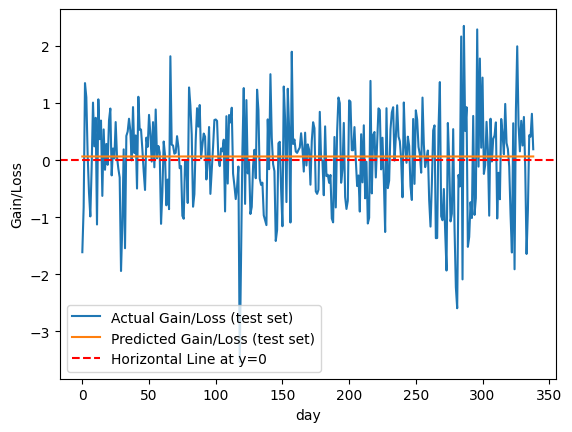

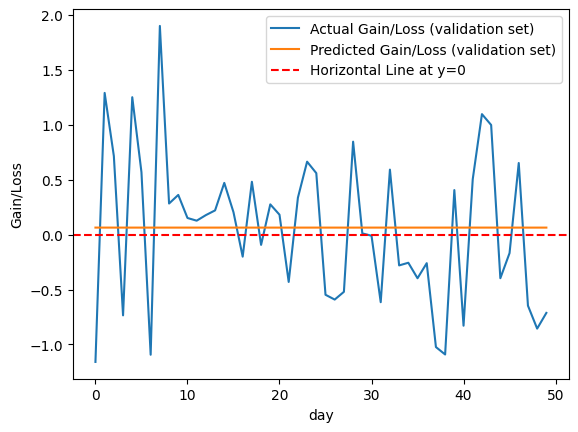

In [13]:
model.train(False)
predictions = []
actual = []

for batch_gain_loss, batch_news, batch_labels in test_loader:
  batch_gain_loss, batch_news, batch_labels = batch_gain_loss.to(device), batch_news.to(device), batch_labels.to(device)
  with torch.no_grad():
    output = model(batch_gain_loss, batch_news)
    predictions.extend(output.cpu().numpy().flatten())
    actual.extend(batch_labels.cpu().numpy().flatten())

def calc_MSE(predictions, actual):
  return np.mean((np.array(predictions) - np.array(actual)) ** 2)

print("MSE predictions vs actual Gain/Loss on test set:   ", calc_MSE(predictions, actual))
print("MSE constant zero vs actual Gain/Loss on test set:   ", calc_MSE(np.zeros_like(actual), actual))
avg_return = 0.1 / 365 # Avarage stock market return is about 10% annually
print("MSE avg_Gain/Loss vs actual Gain/Loss on test set:   ", calc_MSE(np.ones_like(actual) * avg_return, actual))



plt.plot(actual, label='Actual Gain/Loss (test set)')
plt.plot(predictions, label='Predicted Gain/Loss (test set)')
plt.axhline(y=0, color='r', linestyle='--', label='Horizontal Line at y=0')
plt.xlabel('day')
plt.ylabel('Gain/Loss')
plt.legend()
plt.show()


plt.plot(actual[150:200], label='Actual Gain/Loss (validation set)')
plt.plot(predictions[150:200], label='Predicted Gain/Loss (validation set)')
plt.axhline(y=0, color='r', linestyle='--', label='Horizontal Line at y=0')
plt.xlabel('day')
plt.ylabel('Gain/Loss')
plt.legend()
plt.show()
